In [5]:
import numpy as np

import random

import matplotlib.pyplot as plt

from matplotlib.ticker import MultipleLocator, FormatStrFormatter

import copy


# Environment: Grids Worlds

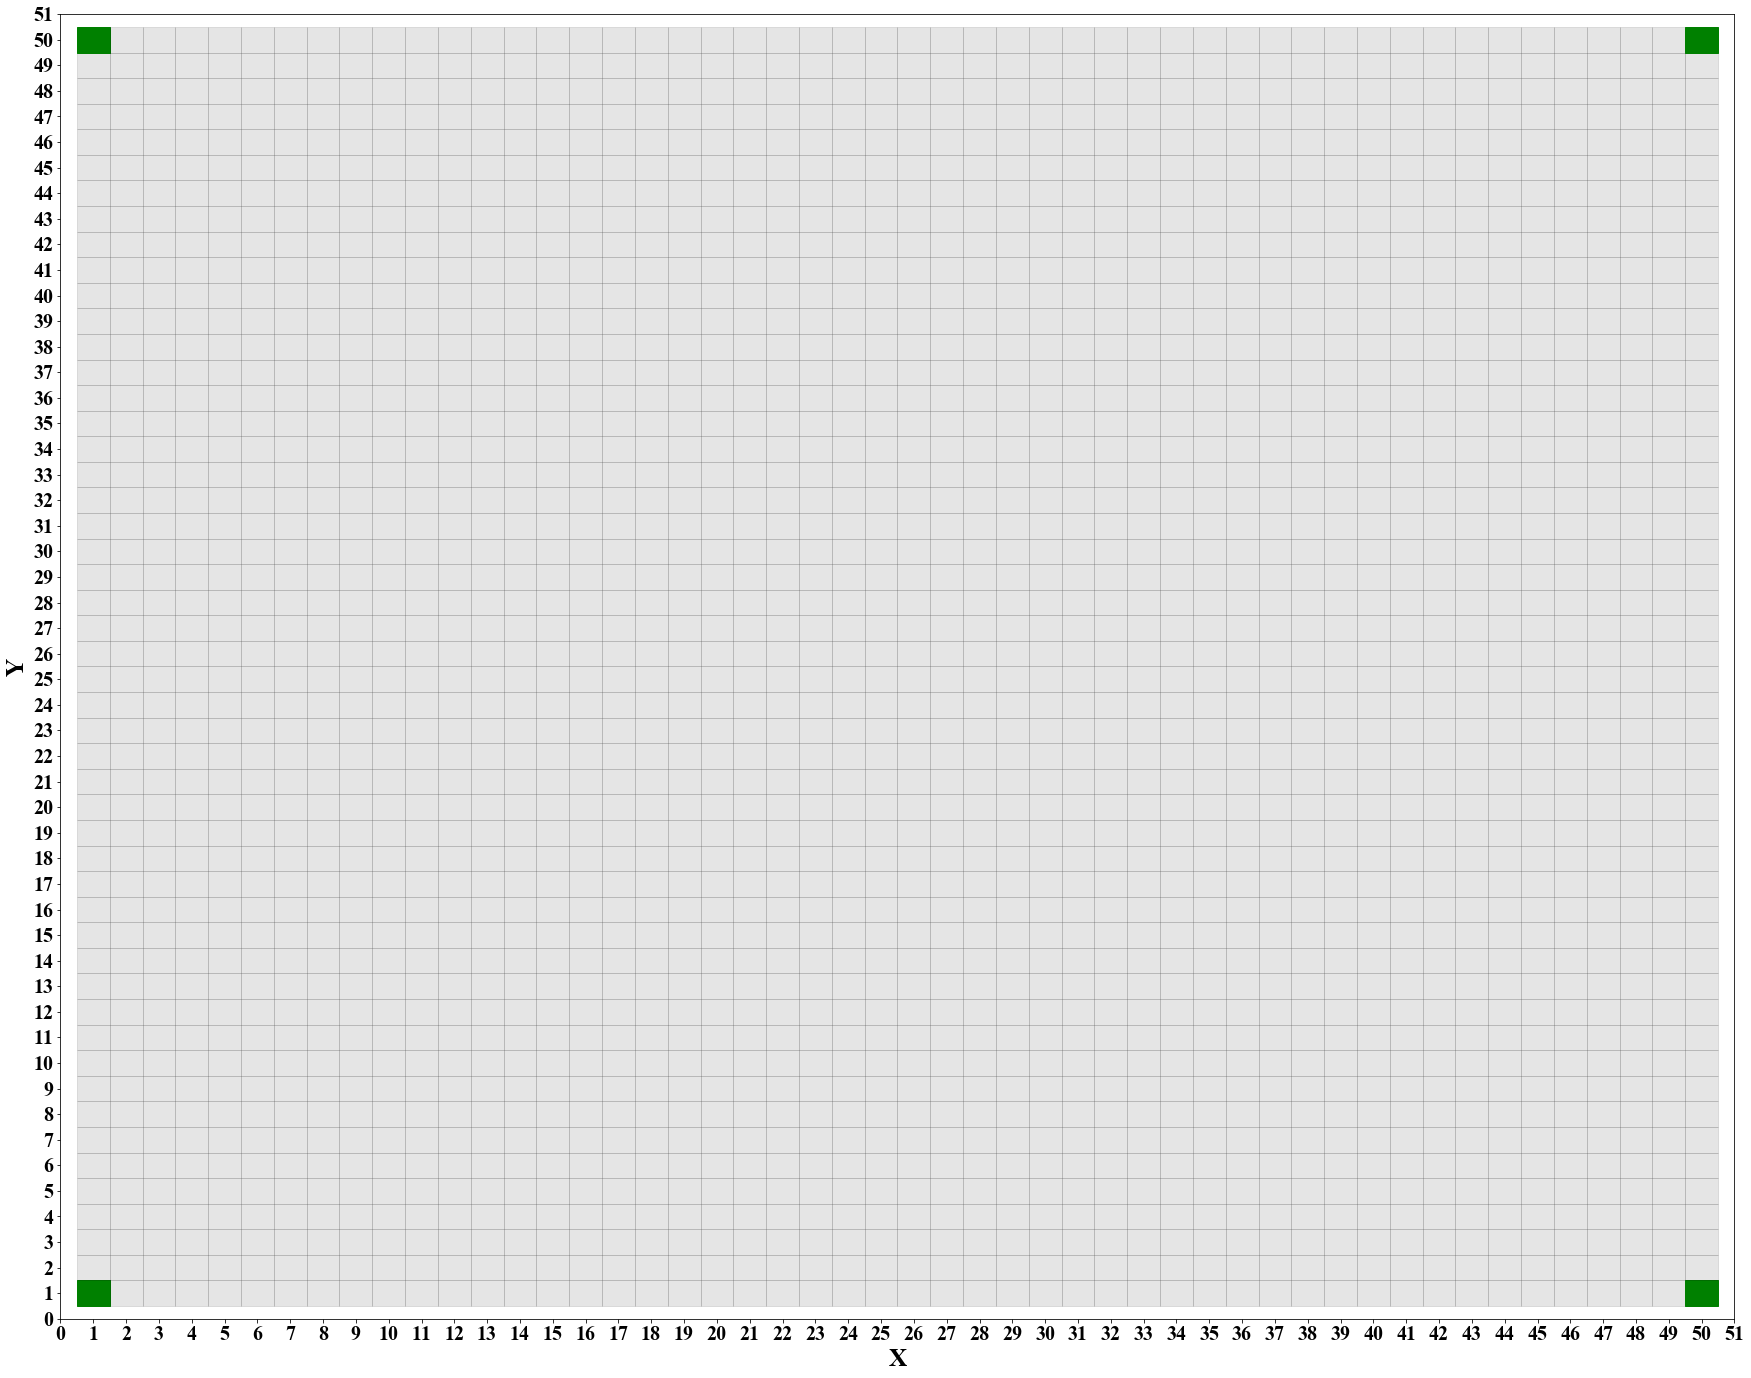

In [11]:
'''State'''

X_coordinate=list(range(1,51,1))

Y_coordinate=list(range(1,51,1))

State=list()

for x in X_coordinate:
    for y in Y_coordinate:
        state=(x,y)
        State.append(state)
        
'''Action'''

Action={state:[(-1,0),(1,0),(0,1),(0,-1),(0,0)] for state in State}

for state in State:
    
    X_=state[0];Y_=state[1];
    
    if X_==1:
        
        Action[state].remove((-1,0))
        
    elif X_==50:
        
        Action[state].remove((1,0))
        
    if Y_==1:
        
        Action[state].remove((0,-1))
        
    elif Y_==50:
        
        Action[state].remove((0,1))


'''Terminate state'''

S_t=[(1,1),(1,50),(50,1),(50,50)]


'''Reward'''

Get_state= lambda s,a: (s[0]+a[0],s[1]+a[1])

Reward={s:{a: 0 if Get_state(s,a) not in S_t else 1 for a in actions} for s,actions in Action.items()}


'''Visualization'''

def Background():
    
    figsize = 30,24

    font_label = {'family' : 'Times New Roman','weight' : 'normal','size': 25}

    font_legend = {'family' : 'Times New Roman','weight' : 'normal','size': 20}


    figure, ax1 = plt.subplots(figsize=figsize)

    labels = ax1.get_xticklabels() + ax1.get_yticklabels()

    [label.set_fontsize(20) for label in labels]

    [label.set_fontname('Times New Roman') for label in labels]

    ax1.set_ylabel('Y',font_label)

    ax1.set_xlabel('X',font_label)


    ax1.set_xlim([0,51])

    ax1.set_ylim([0,51])

    for state in State:

        loc=(state[0]-0.5,state[1]-0.5)

        if state in S_t:

            ax1.add_patch(plt.Rectangle(loc,1,1,color='green', alpha=1))

        else:

            ax1.add_patch(plt.Rectangle(loc,1,1,color='black', alpha=0.1))


    majorLocator   = MultipleLocator(1)

    ax1.yaxis.set_major_locator(majorLocator) 

    ax1.xaxis.set_major_locator(majorLocator)
    
    return figure, ax1


figure, ax1=Background()


In [47]:
'''Generate an Episode'''

def Generate_Episode(State,Action,Reward):
    
    Episodes=list()
    
    ini_state=random.choice(State)
    
    ini_action=random.choice(Action[ini_state])
    
    ini_reward=Reward[ini_state][ini_action]
    
    Episodes.append((ini_state,ini_action,ini_reward))
    
    next_state=Get_state(ini_state,ini_action)
    
    while next_state not in S_t:
        
        ini_state=random.choice(State)
    
        ini_action=random.choice(Action[ini_state])
    
        ini_reward=Reward[ini_state][ini_action]

        Episodes.append((ini_state,ini_action,ini_reward))
    
        next_state=Get_state(ini_state,ini_action)
        
    return Episodes

'''Get a policy'''

def Generate_Policy(State,Action,State_Value):

    Policy={}

    for state in State:

        Action_dic={}

        for action in Action[state]:

            action_state=Get_state(state,action)

            Action_dic[action]=State_Value[action_state]

        optimal_action=max(Action_dic,key=Action_dic.get)

        Policy[state]=optimal_action
        
    return Policy
    
'''Visualization'''

def Plot_Policy(Policy):
    
    figure, ax1=Background()
    
    for state,action in Policy.items():
        
        Start=[state[0],state[1]]
        
        if action!=(0,0):
        
            ax1.arrow(Start[0],\
                      Start[1],\
                      action[0],\
                      action[1],
                      length_includes_head=True,\
                      head_width=0.25,\
                      head_length=0.5,\
                      fc='r',\
                      ec='b')

    plt.show()

## Introduction

In this post, we will use model-free prediction to estimate the value function of an unknown MDP. i.e We will look at policy evaluation of an unknown MDP.

The three main methods that will be explained for model-free predictions are: 

**1. Monte-Carlo Learning**


**2. Temporal-Difference Learning**


**3. TD(λ)**

## Monte-Carlo Learning

Monte Carlo methods are model-free which learn directly from episodes of experience. 

Monte Carlo learns from **complete episodes** with **no bootstrapping**. 

***Notes: Bootstrapping is any test or metric that uses random sampling with replacement, and falls under the broader class of resampling methods. Bootstrapping assigns measures of accuracy (bias, variance, confidence intervals, prediction error, etc.) to sample estimates.***


One drawback to MC is that it can only apply to episodic Markov Decision Processes **where all episodes must terminate**.


### Monte-Carlo Policy Evaluation

**Goal**: Given a policy $\pi$, learn $V_{\pi}$ (value for the policy) from episodes of experience.

\begin{equation}
S_{1},A_{1},R_{2},...,S_{k} \sim \pi
\end{equation}

Monte-Carlo policy evaluation uses empirical mean return instead of expected return. 


Two approaches to evaluate the value function of a policy at a state is to use：

**1. First-Visit Monte-Carlo Policy Evaluation.**

**2. Every-Visit Monte-Carlo Policy Evaluation.**


### First-Visit Monte-Carlo Policy Evaluation

(1) Evaluate the value of state $s$ of a given policy


(2) The **First** time-step ($t$) that state ($s$) is visited in an episode.


(3) Increment counter: $N(s) \leftarrow N(s) + 1$

(4) Increment total return: $S(s) \leftarrow S(s) + G$

(5) Value is estimated by mean return: $V(s) =\frac{S(s)}{N(s)}$

(6) $V(s) → V_{\pi}(s)$ as $N(s) → \infty$


### Incremental Monte-Carlo Updates

Update $V(s)$ incrementally after episode $S_{1},A_{1},R_{2},...,S_{k}$ For each state $S_{t}$ with return $S_{t}$:

\begin{equation}
N(s_{t}) \leftarrow N(s_{t}) + 1
\end{equation}


\begin{equation}
V(s_{t}) \leftarrow V(s_{t}) + \frac{1}{N(s_{t})}(G_{t}-V(s_{t}))
\end{equation}

In non-stationary problems (where things are drifting around and you don’t need to remember things that happened long time ago), we can use the running mean approach, i.e. forget old episodes.

\begin{equation}
V(s_{t}) \leftarrow V(s_{t}) + \alpha(G_{t}-V(s_{t}))
\end{equation}



In [51]:
'''First-Visit Monte-Carlo Policy Evaluation'''


def Get_Gain(Episodes):
    
    Gain={idx:0 for idx,value in enumerate(Episodes)}
    
    Gamma=0.9
    
    for idx,value in enumerate(Episodes):
        
        Gain[idx]=0
        
        for iid,vvl in enumerate(Episodes[idx:]):
            
            Gain[idx]+=vvl[2]*(Gamma**iid)
        
    return Gain


def Extract_First_Visit_State(Episodes):
    
    Visit={}
    
    for idx,value in enumerate(Episodes):
        
        state=value[0]
        
        if state not in Visit.keys():
            
            Visit[state]=idx
        
    return Visit


Min_Freq=0

State_Value={state:0 for state in State}

Frequency={state:0 for state in State}

while Min_Freq<1000:

    Episodes=Generate_Episode(State,Action,Reward)

    Gain=Get_Gain(Episodes)

    Visit=Extract_First_Visit_State(Episodes)

    for state,idx in Visit.items():

        Frequency[state]+=1

        G=Gain[idx]

        State_Value[state]=State_Value[state]+(1.0/Frequency[state])*(G-State_Value[state])

    Min_Freq=min(Frequency.values())


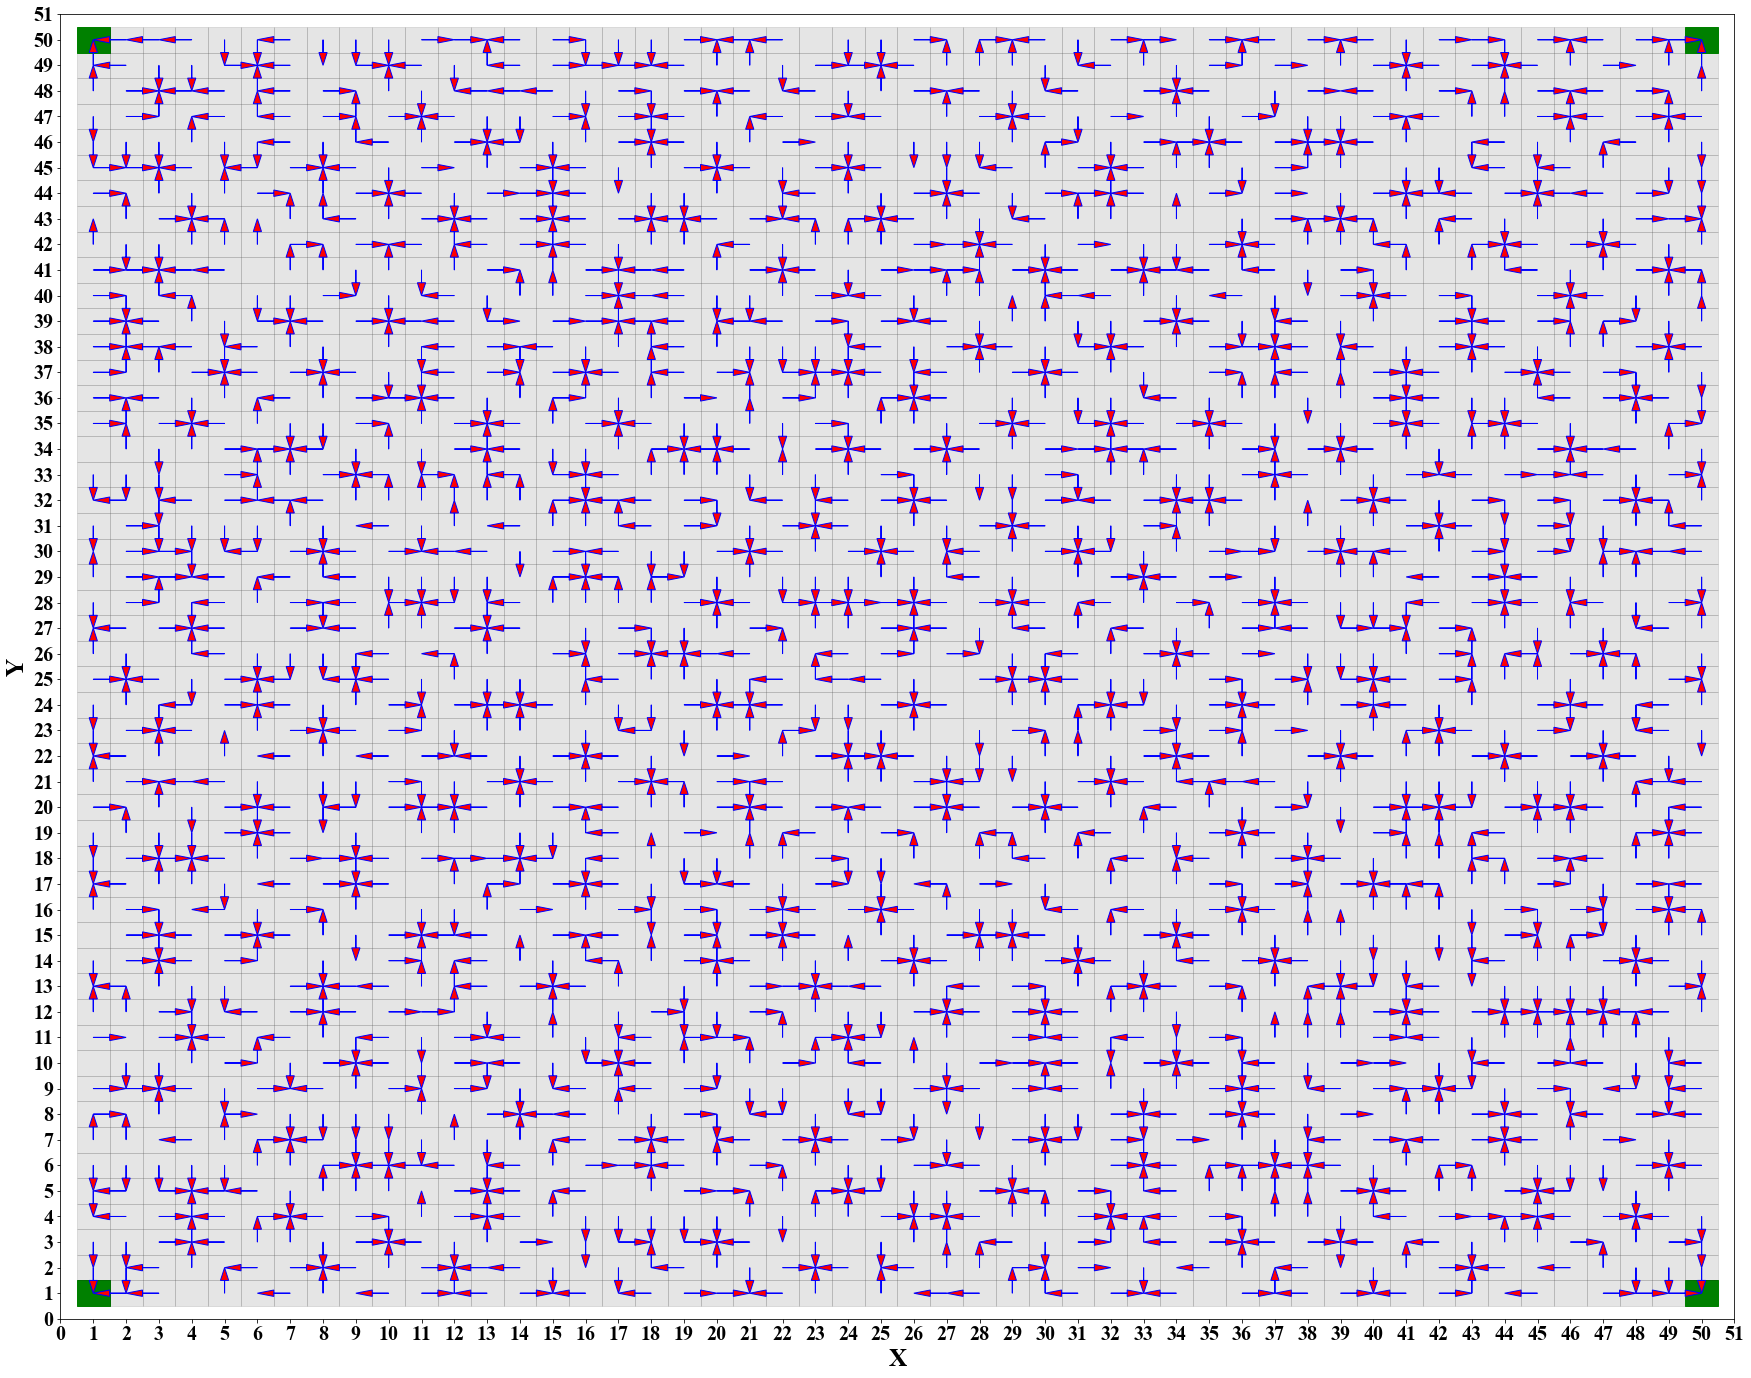

In [52]:
Policy=Generate_Policy(State,Action,State_Value)

Plot_Policy(Policy)

### Every-Visit Monte-Carlo Policy Evaluation

(1) Evaluate the value of state $s$ of a given policy


(2) **Every** time-step ($t$) that state ($s$) is visited in an episode.


(3) Increment counter: $N(s) \leftarrow N(s) + 1$

(4) Increment total return: $S(s) \leftarrow S(s) + G$

(5) Value is estimated by mean return: $V(s) =\frac{S(s)}{N(s)}$

(6) $V(s) → V_{\pi}(s)$ as $N(s) → \infty$


In [53]:
'''First-Visit Monte-Carlo Policy Evaluation'''


def Get_Gain(Episodes):
    
    Gain={idx:0 for idx,value in enumerate(Episodes)}
    
    Gamma=0.9
    
    for idx,value in enumerate(Episodes):
        
        Gain[idx]=0
        
        for iid,vvl in enumerate(Episodes[idx:]):
            
            Gain[idx]+=vvl[2]*(Gamma**iid)
        
    return Gain


def Extract_Visit_State(Episodes):
    
    Visit_states=[value[0] for value in Episodes]
    
    Visit_states=list(set(Visit_states))
    
    Visit={state:[] for state in Visit_states}
    
    for idx,value in enumerate(Episodes):
        
        state=value[0]
            
        Visit[state].append(idx)
        
    return Visit


Min_Freq=0

State_Value={state:0 for state in State}

Frequency={state:0 for state in State}

while Min_Freq<1000:
    
    Episodes=Generate_Episode(State,Action,Reward)

    Gain=Get_Gain(Episodes)

    Visit=Extract_Visit_State(Episodes)
    
    for state,idxs in Visit.items():
        
        for idx in idxs:

            Frequency[state]+=1

            G=Gain[idx]

            State_Value[state]=State_Value[state]+(1.0/Frequency[state])*(G-State_Value[state])
            
    Min_Freq=min(Frequency.values())

    
State_Value


{(1, 1): 0.3412001928357784,
 (1, 2): 0.2815071378868348,
 (1, 3): 0.011712264638734083,
 (1, 4): 0.015294816090727833,
 (1, 5): 0.009584112335278653,
 (1, 6): 0.009945659613054146,
 (1, 7): 0.015103038170320361,
 (1, 8): 0.00867449856280981,
 (1, 9): 0.010520455303483014,
 (1, 10): 0.012530012600900578,
 (1, 11): 0.010171027601711931,
 (1, 12): 0.010393029527528146,
 (1, 13): 0.009465306776379407,
 (1, 14): 0.009005118625013487,
 (1, 15): 0.01695338192174135,
 (1, 16): 0.014566103315639668,
 (1, 17): 0.010280790177285757,
 (1, 18): 0.018578335990058203,
 (1, 19): 0.01321129232982293,
 (1, 20): 0.009011557382221144,
 (1, 21): 0.009104617427631696,
 (1, 22): 0.01256525228163408,
 (1, 23): 0.0075891855331859815,
 (1, 24): 0.006599577851134369,
 (1, 25): 0.01004970184394997,
 (1, 26): 0.011573169200933497,
 (1, 27): 0.011585116645579954,
 (1, 28): 0.011263851082364894,
 (1, 29): 0.009753703424963072,
 (1, 30): 0.012308605569933788,
 (1, 31): 0.010067832696999473,
 (1, 32): 0.0119628601124

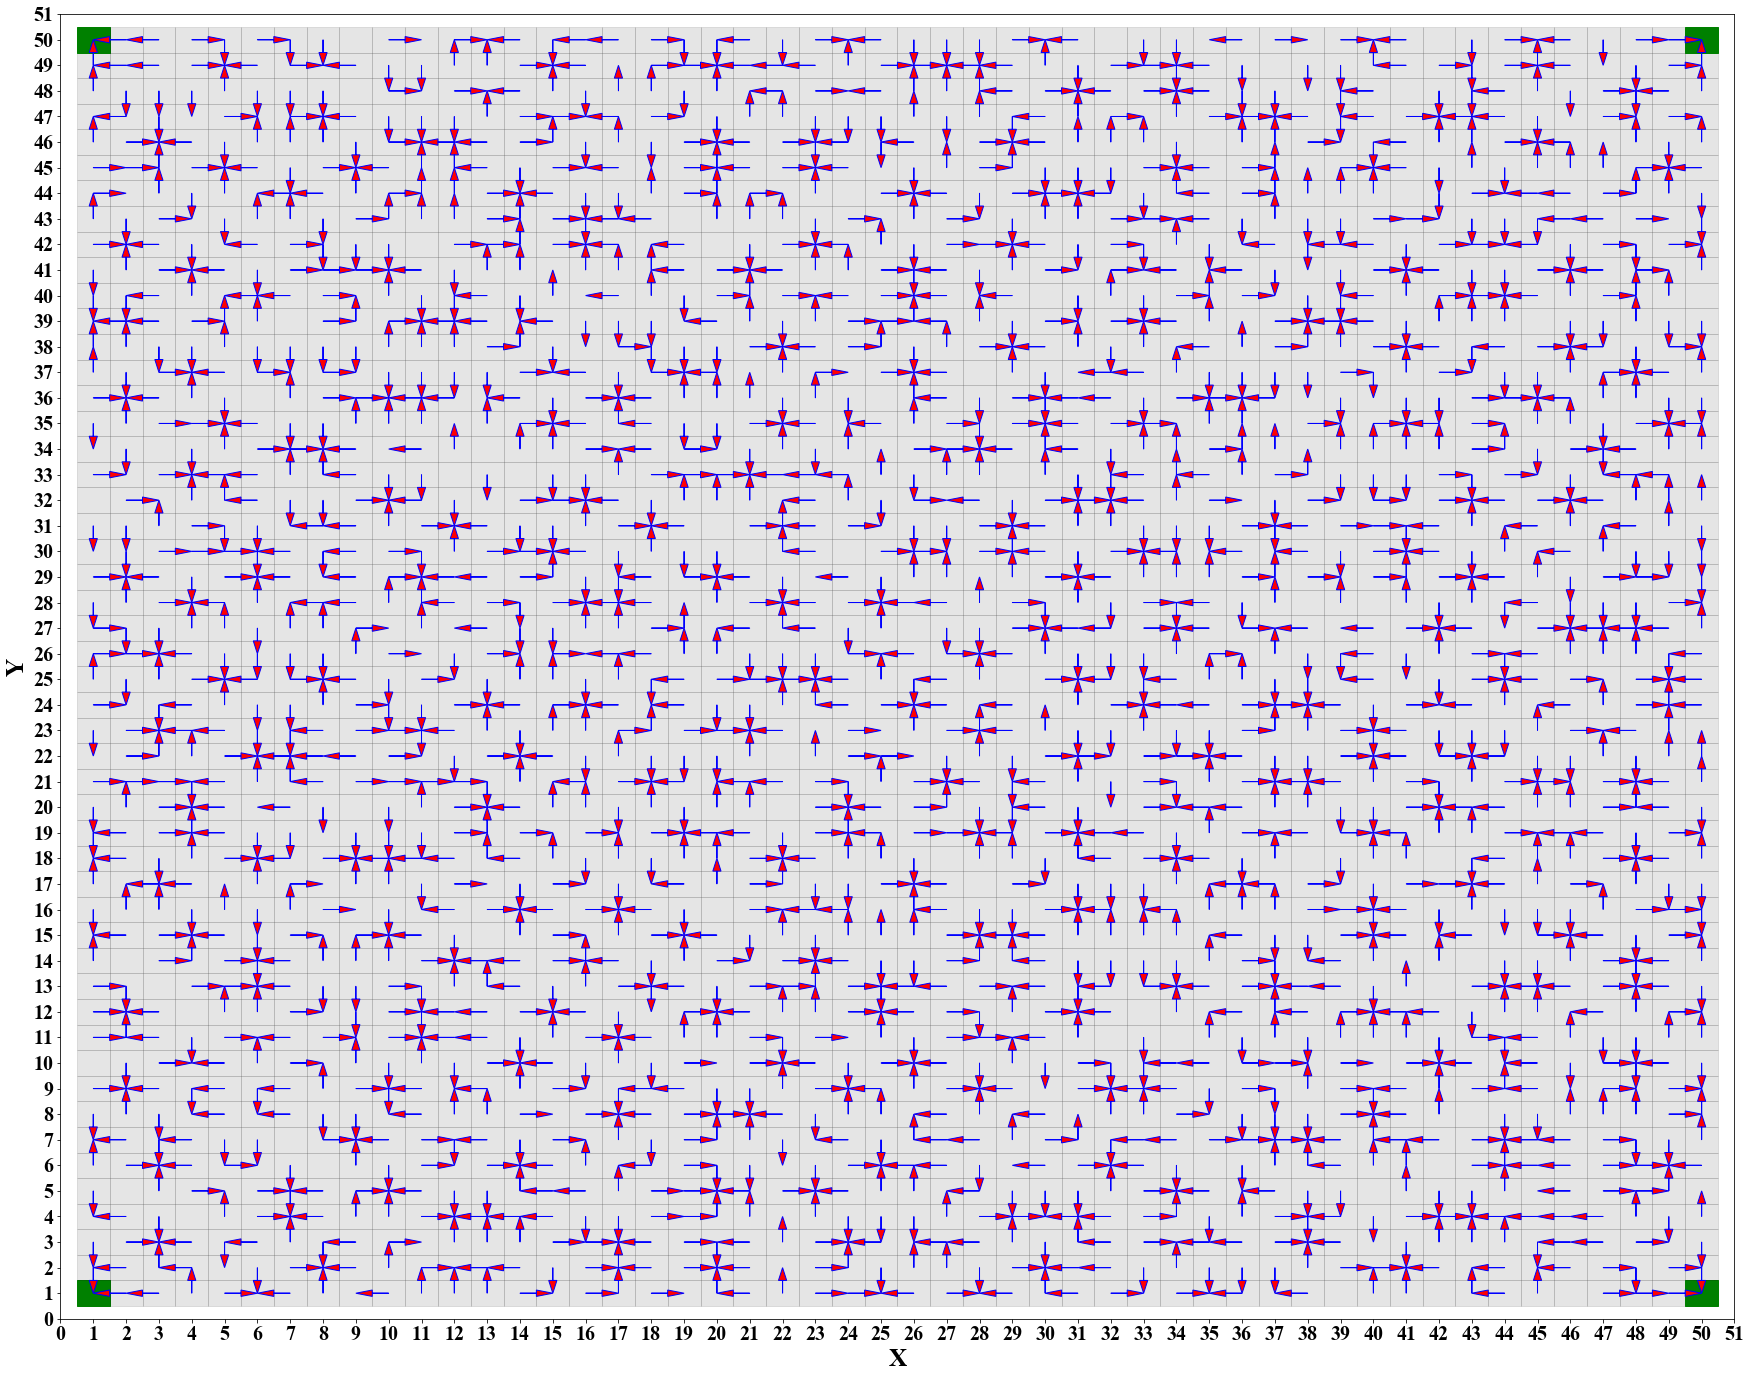

In [54]:
Policy=Generate_Policy(State,Action,State_Value)

Plot_Policy(Policy)

## Temporal-Difference Learning


1. Temporal-Difference is model-free. 

2. Temporal Difference methods learn directly from experience/interaction with the environment. 

3. Temporal Difference learns from incomplete episodes, by bootstrapping (update the guess of the value function).


**GOAL**:  learn $V_{\pi}$ online from experience under policy $\pi$

If we were to apply incremental every-visit Monte-Carlo we update the value $V(s_{t})$ towards the actual return $G_{t}$

\begin{equation}
V(s_{t}) \leftarrow V(s_{t}) + \alpha(G_{t}-V(s_{t}))
\end{equation}


Simplest temporal-difference learning algorithm: TD(0):

Update value $V(s_{t})$ toward estimated return $R_{t+1}+\gamma V(s_{t+1})$:

\begin{equation}
V(s_{t}) \leftarrow V(s_{t}) + \alpha(R_{t+1}+\gamma V(s_{t+1})-V(s_{t}))
\end{equation}


**TD target**:$R_{t+1}+\gamma V(s_{t+1})$

**TD error**: $R_{t+1}+\gamma V(s_{t+1})-V(s_{t})$


## TD and MC

### TD can learn before knowing the final outcome

TD can learn online after every step

MC must wait until end of episode before return is known

TD can learn without the final outcome


### TD can learn from incomplete sequences

MC can only learn from complete sequences

TD works in continuing (non-terminating) environments

MC only works for episodic (terminating) environments


### Comments

Return $G_{t}=R_{t+1}+\gamma R_{t+2}+...+\gamma^{T-1} R_{T}$ is unbiased estimate of $V_{\pi}(s_{t})$

True TD target $R_{t+1}+\gamma V_{\pi}(s_{t+1})$ is unbiased estimate of $V_{\pi}(s_{t})$

TD target $R_{t+1}+\gamma V(s_{t+1})$ is biased estimate of $V_{\pi}(s_{t})$

#### MC has high variance, zero bias

Good convergence properties (even with function approximation)

Not very sensitive to initial value

Very simple to understand and use

#### TD has low variance, some bias

Usually more efficient than MC

$TD(0)$ converges to $V_{\pi}(s)$ (but not always with function approximation)

More sensitive to initial value

### Certainty Equivalence

#### MC converges to solution with minimum mean-squared error

Best fit to the observed returns:

\begin{equation}
\sum_{k}\sum_{t}(G_{t}^{k}-V(s_{t}^{k}))^{2}
\end{equation}

### TD(0) converges to solution of max likelihood Markov mode

